In [1]:
import pandas as pd
import numpy as np
import math
import glob
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import cooler
from src.Graph_creation import compute_nx_graph_from_regions, compute_ptg_graph_from_regions,compute_ptg_graph_from_sites

In [2]:
coolerpath ={'WT':'/disk2/dh486/cooler_files/WT/manually_downsampled/KR/KR_downsampled_WT_merged_10000.cool',
             'KO':'/disk2/dh486/cooler_files/KO/KR/KR_KO_merged_10000.cool'
            }

In [3]:
x = pd.read_table("Data/archive/rnaseq.tsv")

In [4]:
x, bad_sites = compute_ptg_graph_from_sites([coolerpath['WT'],coolerpath['KO']],
                                   {'chr2':np.array([10658971,11658978,13658978,15658978,17658978]),
                                    'chr3':np.array([8651256,10658971,10678978,11658978])
                                   },
                                   names = {'chr2': ['Ppp2r2c','reg2','reg3','reg4','reg5'],
                                            'chr3': ['Ppp3r3c','reg4','reg6','reg7']
                                           },
                                   balance = True, 
                                   join = False,
                                 record_cistrans_interactions = False,
                                   record_node_chromosome_as_onehot = False
                                  )

x

{'chr2': {'edge_index': array([[0., 0., 1., 1., 1., 1., 2., 2., 3., 4., 4.],
         [0., 1., 0., 1., 2., 4., 1., 2., 3., 1., 4.]]),
  'edge_attrs': array([[ 68.54391516, 132.44437687],
         [  5.29613656,   0.        ],
         [  5.29613656,   0.        ],
         [ 62.14922729, 125.54026079],
         [  0.        ,   1.07064205],
         [  1.95063539,   0.        ],
         [  0.        ,   1.07064205],
         [ 50.34215202, 159.66910041],
         [ 33.88699289, 159.50590195],
         [  1.95063539,   0.        ],
         [ 36.36661776, 108.50997462]]),
  'x': [],
  'cooler_idxs': [array([20613, 20713, 20913, 21113, 21313])],
  'name': array(['Ppp2r2c', 'reg2', 'reg3', 'reg4', 'reg5'], dtype='<U7')},
 'chr3': {'edge_index': array([[0., 0., 0., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.],
         [0., 2., 3., 1., 2., 3., 0., 1., 2., 3., 0., 1., 2., 3.]]),
  'edge_attrs': array([[ 48.69851365, 110.72743322],
         [  1.24798179,   0.        ],
         [  0.       

In [5]:
bad_sites['chr2']

array([], dtype=int64)

In [6]:
x = compute_ptg_graph_from_regions([coolerpath['WT'],coolerpath['KO']],
                                   {'chr2':np.array([[8651256,10658971],
                                                     [10678978,11658978],
                                                     [12678978,13658978],
                                                     [14678978,15658978],
                                                     [16678978,17658978]
                                                    ]),
                                    'chr3':np.array([[8651256,10658971],
                                                     [10678978,11658978]
                                                    ])
                                   },
                                   names = {'chr2': ['Ppp2r2c','reg2'],
                                            'chr3': ['Ppp3r3c','reg4']
                                           },
                                   balance = True, 
                                   join = False,
                                   backbone = True,
                                   record_backbone_interactions = True,
                                   record_cistrans_interactions = False,
                                   record_node_chromosome_as_onehot = False
                                  )

x

{'chr2': [{'edge_index': array([[  0.,   0.,   0., ..., 200., 200., 200.],
          [  0.,   1.,   2., ..., 198., 199., 200.]]),
   'edge_attrs': array([[ 45.51099203, 138.71464153,   0.        ],
          [ 71.47081371, 144.8921595 ,   1.        ],
          [ 29.6403106 ,  50.38548857,   0.        ],
          ...,
          [ 41.5707432 ,  67.55735544,   0.        ],
          [113.3756405 , 151.55135175,   1.        ],
          [ 68.54391516, 132.44437687,   0.        ]]),
   'x': [],
   'cooler_idxs': array([20413, 20414, 20415, 20416, 20417, 20418, 20419, 20420, 20421,
          20422, 20423, 20424, 20425, 20426, 20427, 20428, 20429, 20430,
          20431, 20432, 20433, 20434, 20435, 20436, 20437, 20438, 20439,
          20440, 20441, 20442, 20443, 20444, 20445, 20446, 20447, 20448,
          20449, 20450, 20451, 20452, 20453, 20454, 20455, 20456, 20457,
          20458, 20459, 20460, 20461, 20462, 20463, 20464, 20465, 20466,
          20467, 20468, 20469, 20470, 20471, 20472

In [7]:
def draw_circular(graph, ax, cmap = plt.cm.Blues, weightnorm = None):
    pos = nx.circular_layout(graph)
    #nx.draw_networkx_nodes(graph, pos = pos,node_size=30,ax=ax)

    edges,weights = zip(*nx.get_edge_attributes(graph,'weight').items())

    if weightnorm is None:
        weightnorm = np.percentile(weights,90)
    normalize = mpl.colors.Normalize(vmin=0, vmax=weightnorm)
    for jdx in np.argsort(weights):
        nx.draw_networkx_edges(graph, 
                           pos, 
                           ax = ax,
                           edgelist=[edges[jdx]], 
                           edge_color = cmap(normalize(weights[jdx])), 
                           connectionstyle='arc3,rad=0.3')

    labels = {item[0]: item[1].split(":")[1].split("-")[0] for item in graph.nodes(data='bin_regions') if int(item[0])%20 == 0}
    poslabels = nx.draw_networkx_labels(graph,{key: 1.1*pos[key] for key in pos},labels = labels,ax= ax)
    
    return weightnorm, pos

def highlight_nodes(graph, nodes,ax, pos, **kwargs):
    nx.draw_networkx_nodes(graph, pos = pos,ax=ax, **kwargs)
    
def compare_gene(gene_reg, gene_name):
    gene_intregs = gene_reg.split(":")[1]
    gene_intregs = [int(item.replace(',', '')) for item in gene_intregs.split("-")]
    c = cooler.Cooler(coolerpath['WT'])
    mynodes = c.bins().fetch(gene_reg).index.values

    regions = {
        gene_reg.split(":")[0]: np.array([[gene_intregs[0]-int(4e5),gene_intregs[1]+int(4e5)]])
    }
    chrom = gene_reg.split(":")[0]
    graphs = {cond: compute_nx_graph_from_regions(coolerpath[cond],
                                                  regions,
                                                  join= True,
                                                  force_disjoint = True,
                                                  balance = True) for cond in ['WT','KO']}

    fig, ax = plt.subplots(1,2, figsize = (16,8))
    fig.tight_layout()
    for idx in [0,1]:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].spines['top'].set_visible(False)
        ax[idx].spines['bottom'].set_visible(False)
    
    pos = {}
    KO_weightnorm,pos['KO'] = draw_circular(graphs['KO'],
                                        ax[0],
                                        cmap = plt.cm.Reds)
    ax[0].set_title(f"KO contacts\n{graphs['KO'].graph['regions']}\n{gene_name} highlighted",
                size = 15)

    nx.draw_networkx_nodes(graphs['KO'],
                       pos = pos['KO'],
                       ax=ax[0],
                       node_size = 50, 
                       node_color = 'yellow', 
                       nodelist = mynodes)

    WT_weightnorm, pos['WT'] = draw_circular(graphs['WT'],
                                         ax[1],
                                         weightnorm = KO_weightnorm)
    ax[1].set_title(f"WT contacts\n{graphs['WT'].graph['regions']}\n{gene_name} highlighted",
                size = 15)
    nx.draw_networkx_nodes(graphs['WT'],
                       pos = pos['WT'],
                       ax=ax[1],
                       node_size = 50, 
                       node_color = 'yellow', 
                       nodelist = mynodes)

    for idx in [0,1]:
        ax[idx].set_xlim([-1.3,1.2])
        ax[idx].set_ylim([-1.2,1.2])
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])


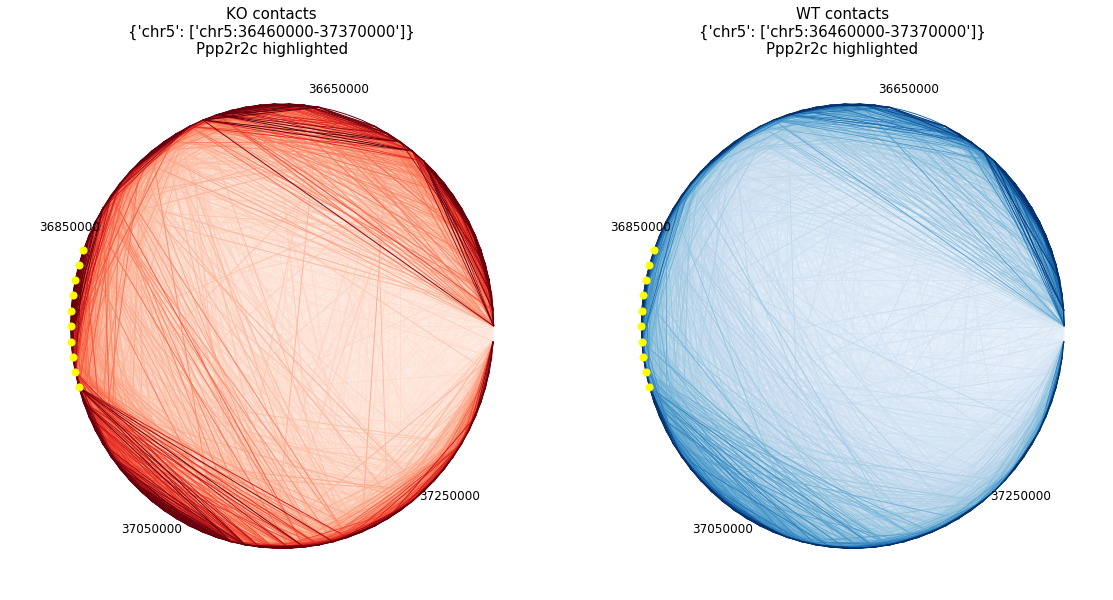

In [8]:
compare_gene(gene_reg = "chr5:36,868,513-36,955,078",gene_name = 'Ppp2r2c')

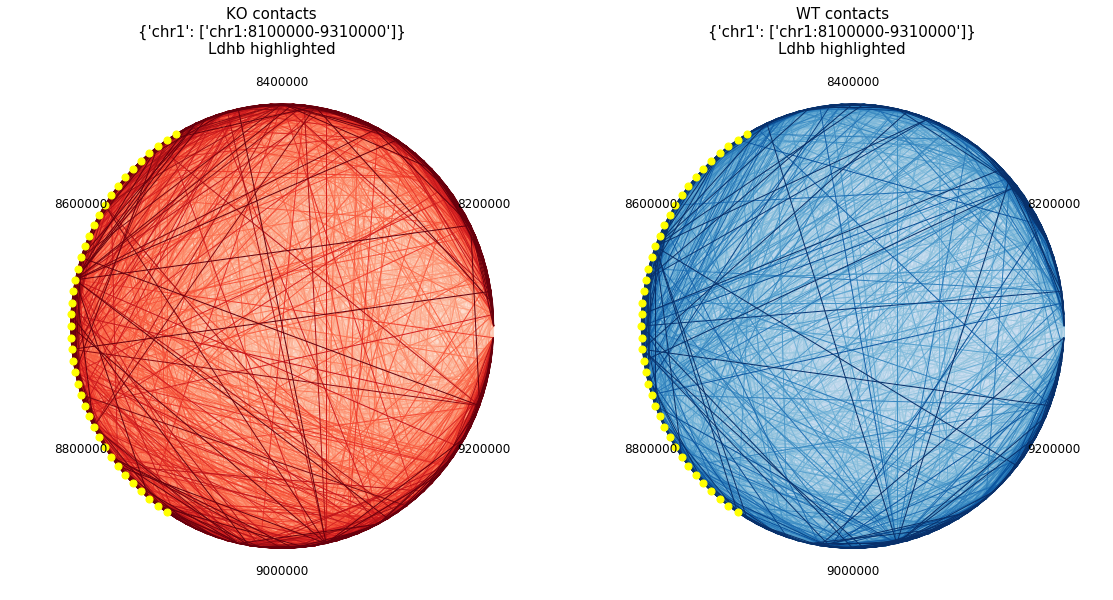

In [9]:
compare_gene(gene_reg = 'chr1:8,500,000-8,900,000',gene_name = 'Ldhb')

In [9]:
graphs = compute_nx_graph_from_regions(coolerpath['WT'],
                                       {'chr1':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr2':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr3':np.array([[8100000,9310000],
                                                         [9340000,10110000]])
                                       },
                                       balance = True, join = True, force_disjoint = True)



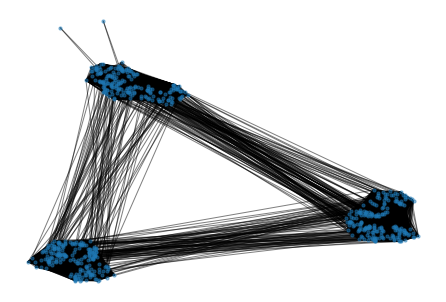

In [10]:
nx.draw(graphs,node_size = 10,alpha = 0.5)

In [11]:
graphs = compute_nx_graph_from_regions(coolerpath['WT'],
                                       {'chr1':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr2':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr3':np.array([[8100000,9310000],
                                                         [9340000,10110000]])
                                       },
                                       balance = True)



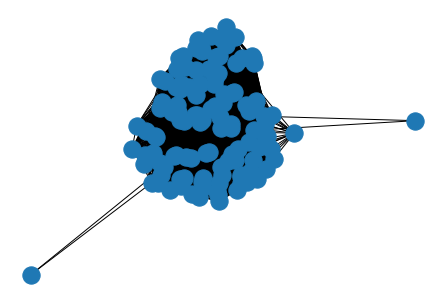

In [12]:
nx.draw(graphs['chr1']['chr1'][0])

In [6]:
def symlog(arr):
    out = arr.copy()
    out[out>1] = 1 + np.log(out[out>1])
    
    return out

In [38]:
tmp

,chromosome,prom_start,prom_end,lfc,promoter_ids,Mbd3,WT_CTCF,KO_CTCF,WT_Smc3,KO_Smc3,...,48h_H3K27ac,WT_Nanog,KO_Nanog,WT_Klf4,KO_Klf4,0h_H3K4me3,24h_H3K4me3,KO_Chd4,24h_Chd4,48h_Chd4
0,chr3,108145651,108147137,0.052546,ENSMUSG00000000001,1.016534,0.118015,0.073453,0.108347,0.087963,...,1.275416,7.440179,3.169851,11.147364,16.007750,3.566193,4.425987,0.065828,5.696360,5.962967
1,chrX,77853128,77854614,-0.002751,ENSMUSG00000000003,0.141153,0.013883,0.028603,0.018350,0.020550,...,0.003050,1.015177,1.390251,0.959643,1.339447,0.005850,0.005172,0.011066,0.000000,0.001018
2,chr16,18811096,18812978,-0.112532,ENSMUSG00000000028,0.816803,0.077651,0.073361,0.099435,0.104082,...,1.603719,12.657405,3.788830,3.849850,3.842063,5.410285,6.831375,0.057152,1.266577,1.329458
3,chr7,142576415,142579134,0.528073,ENSMUSG00000000031,0.586868,0.024910,0.040872,0.026896,0.039931,...,0.091869,1.506134,0.725816,3.981720,1.657484,0.141566,0.112995,0.026699,1.275280,1.408483
4,chrX,161161759,161163555,-0.474546,ENSMUSG00000000037,0.504300,0.074988,0.039030,0.025079,0.023070,...,0.105798,2.852070,1.214071,2.560380,4.149853,0.830446,0.623273,0.038307,1.251481,1.964131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41464,chr17,29548808,29550294,-0.014677,ENSMUSG00000099329,0.991619,0.107378,0.056800,0.044834,0.047584,...,0.886993,4.493681,2.038732,5.073977,4.138550,2.344280,2.701650,0.052987,4.124379,6.509595
41465,chr7,44537683,44539169,0.427555,ENSMUSG00000099330,0.950588,0.068006,0.054347,0.018210,0.057334,...,0.154850,2.276802,1.559335,4.220276,4.888617,0.063370,0.052476,0.048840,3.975906,4.255727
41466,chr11,46169096,46170582,-0.002751,ENSMUSG00000099331,0.492773,0.034510,0.053239,0.037403,0.043283,...,0.078388,3.297451,1.309919,2.964481,1.670016,0.009594,0.034043,0.019718,0.058175,0.054694
41467,chr17,85617076,85618562,-0.002751,ENSMUSG00000099332,1.733329,0.107599,0.064081,0.062178,0.074885,...,0.247960,3.778322,1.589783,5.817864,8.032394,1.390905,0.913376,0.051484,5.640151,5.920132


In [89]:
tmp = pd.read_csv("Data/raw/target.tsv",
            sep="\t")
arr = tmp.values[:,5:].astype('float')
numchip = arr.shape[1]

##Select top 22k promoters based off total amount of signal
#idxs = np.argsort(np.sum(colscaled_arr,axis=1))[-22000:]
#arr = arr[idxs,:]
targ = tmp['target'].values
#targ = targ[idxs]

In [90]:
from sklearn.preprocessing import PowerTransformer as PT
from sklearn.preprocessing import StandardScaler as SS
from sklearn.preprocessing import RobustScaler as RS

Text(0.5, 0, 'Power\nTransformer')

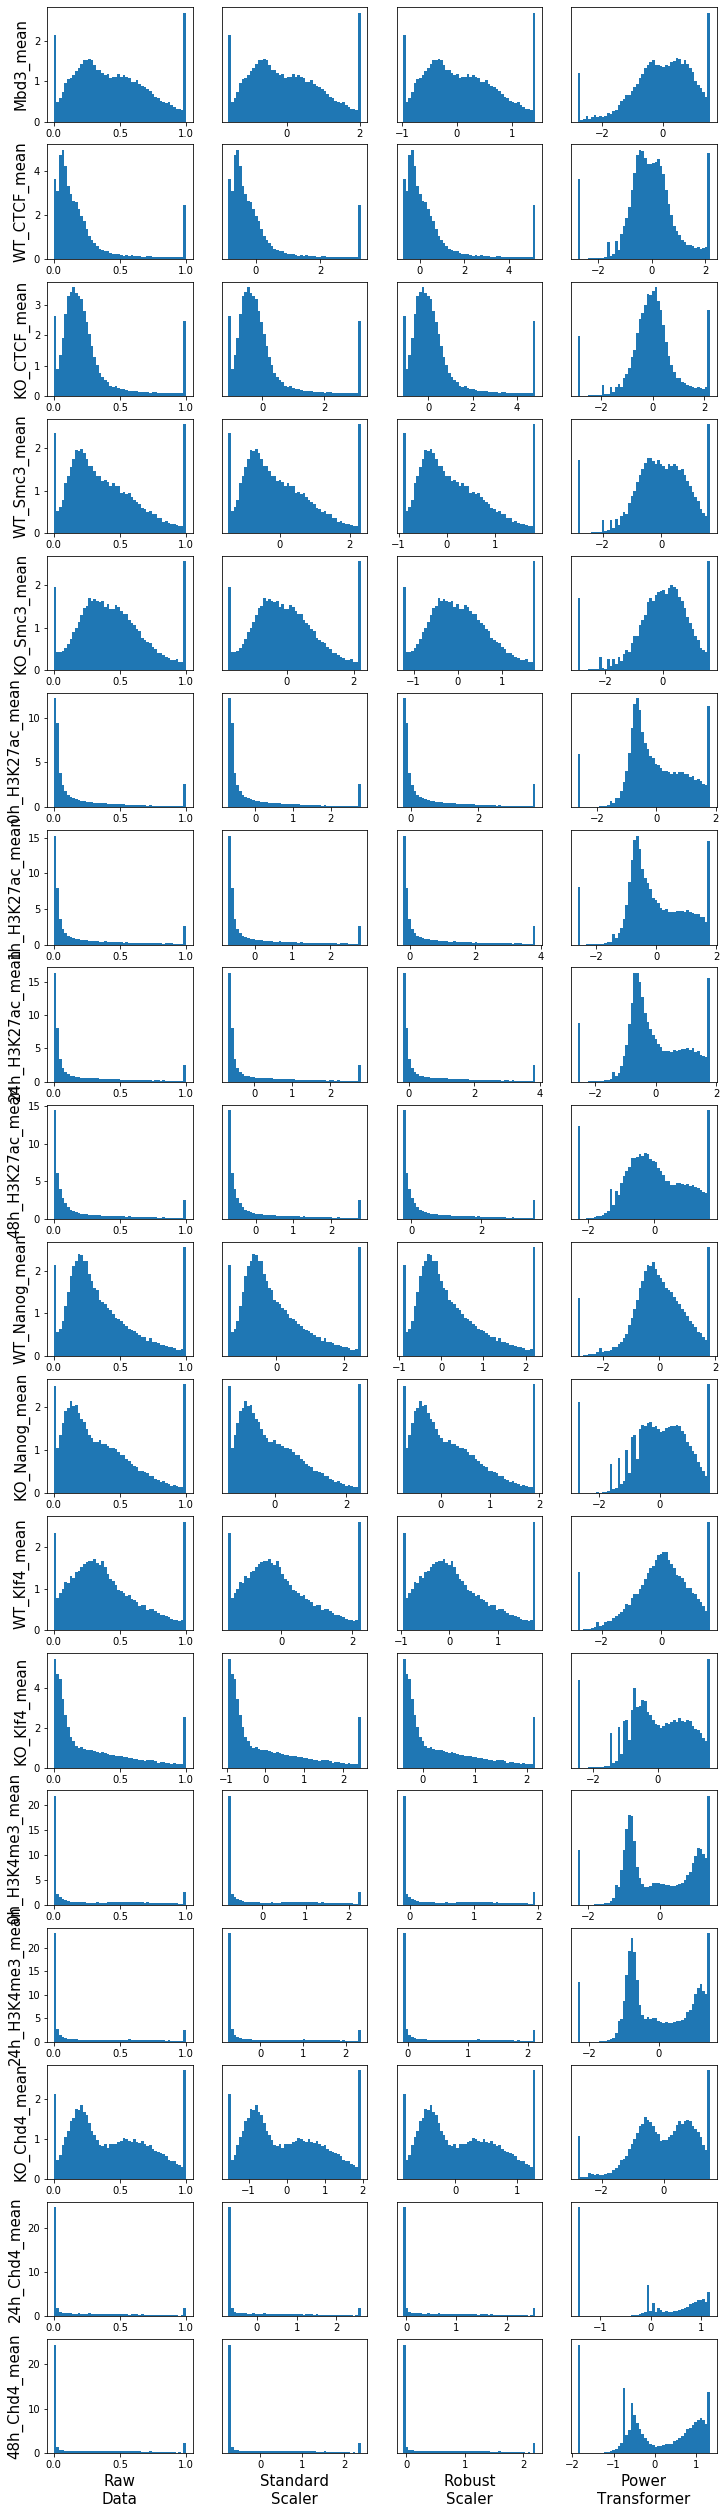

In [91]:
#Test out some feature scaling on the ChIP
fig, ax = plt.subplots(numchip,4,figsize = (12,45))

scalerSS = SS()
scalerSS.fit(arr)
arrSS = scalerSS.transform(arr)
scalerRS = RS()
scalerRS.fit(arr)
arrRS = scalerRS.transform(arr)
scalerPT = PT(method = 'box-cox')
scalerPT.fit(arr+0.01*np.min(arr[arr>0]))
arrPT = scalerPT.transform(arr+0.01*np.min(arr[arr>0]))

for jdx in np.arange(numchip):
    ax[jdx,0].set_ylabel(tmp.columns.values[5+jdx],
                         size = 15)
    ax[jdx,0].hist(arr[:,jdx],
                   bins = 50,
                   density =True)
    ax[jdx,1].hist(arrSS[:,jdx],
                   bins = 50,
                   density=True)
    ax[jdx,2].hist(arrRS[:,jdx],
                   bins = 50,
                   density=True)
    ax[jdx,3].hist(arrPT[:,jdx],
                   bins = 50,
                   density =True)
    
    for idx in [1,2,3]:
        ax[jdx,idx].set_yticks([])
        
ax[-1,0].set_xlabel('Raw\nData',size = 15) 
ax[-1,1].set_xlabel('Standard\nScaler',size = 15) 
ax[-1,2].set_xlabel('Robust\nScaler',size = 15) 
ax[-1,3].set_xlabel('Power\nTransformer',size = 15) 

In [92]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

#Cluster promoters based off min_max scaled data avoiding outliers
cluster_arr = arr.copy()

#Image promoters based on min_max scaled data avoiding outliers 
myarr = cluster_arr.copy()

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    R = dendrogram(linkage_matrix, **kwargs)
    return R, counts

# setting distance_threshold=0 ensures we compute the full tree.
model1 = AgglomerativeClustering(distance_threshold=0,
                                 n_clusters=None,
                                 linkage='ward')

model1 = model1.fit(cluster_arr)

#setting distance_threshold=0 ensures we compute the full tree.
model2 = AgglomerativeClustering(distance_threshold=0, 
                                 n_clusters=None, 
                                 linkage = 'ward')

model2 = model2.fit(np.array(cluster_arr).T)

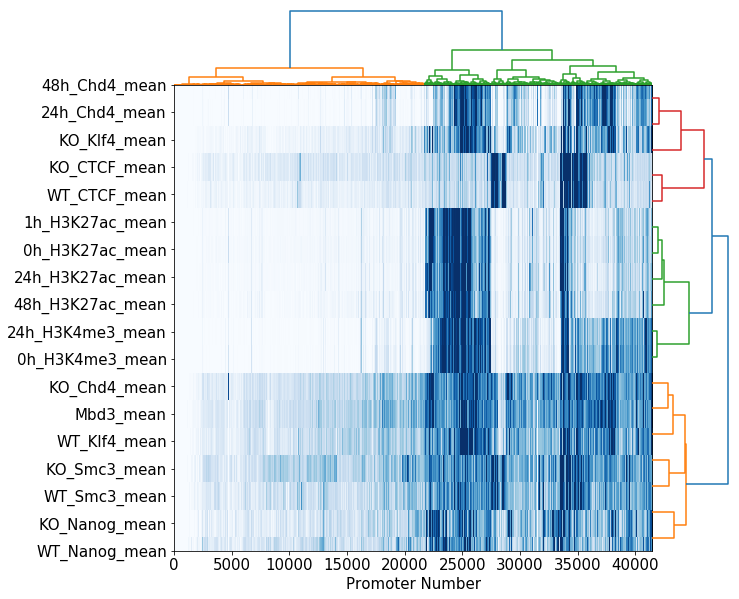

In [93]:
import sys
import matplotlib.gridspec as grd

featnames = tmp.columns.values[5:]

sys.setrecursionlimit(2000)

fig = plt.figure(figsize = (10,10))
fig.tight_layout()

gs = grd.GridSpec(2,
                  2,
                  height_ratios=[1,6],
                  width_ratios=[6,1],
                  hspace=0,
                  wspace=0)

ax1 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[0,0])
ax3 = plt.subplot(gs[1,1])

ax2.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax3.xaxis.set_visible(False)

R2 = plot_dendrogram(model2,
                     truncate_mode='level',
                     p=60,
                     get_leaves = True,
                     orientation = 'right',
                     ax = ax3,
                     distance_sort = 'ascending')[0]
R1 = plot_dendrogram(model1,
                     truncate_mode='level',
                     p=2000,
                     get_leaves = True,
                     orientation = 'top',
                     ax = ax2,
                     distance_sort = 'ascending')[0]

img1 = myarr[np.array(R1['leaves']),:]
img1 = img1[:,np.array(R2['leaves'])[::-1]]

ax1.imshow(img1.T, 
           cmap = plt.cm.Blues, 
           vmin = 0, 
           vmax = 1, 
           aspect = 'auto')
reorderedtracks = [featnames[i] for i in np.array(R2['leaves'])[::-1]]
yticks = ax1.set_yticks(np.arange(len(reorderedtracks)))
yticklabs = ax1.set_yticklabels(reorderedtracks)
ax1.set_xlabel("Promoter Number", size = 15)
ax1.tick_params(labelsize = 15)
#ax2.set_title("Excluding signal poor promoters", size = 20)
for ax in [ax2,ax3]:
    ax.spines['top'].set_visible('false')
    ax.spines['bottom'].set_visible('false')
    ax.spines['left'].set_visible('false')
    ax.spines['right'].set_visible('false')
    ax.axis('off')

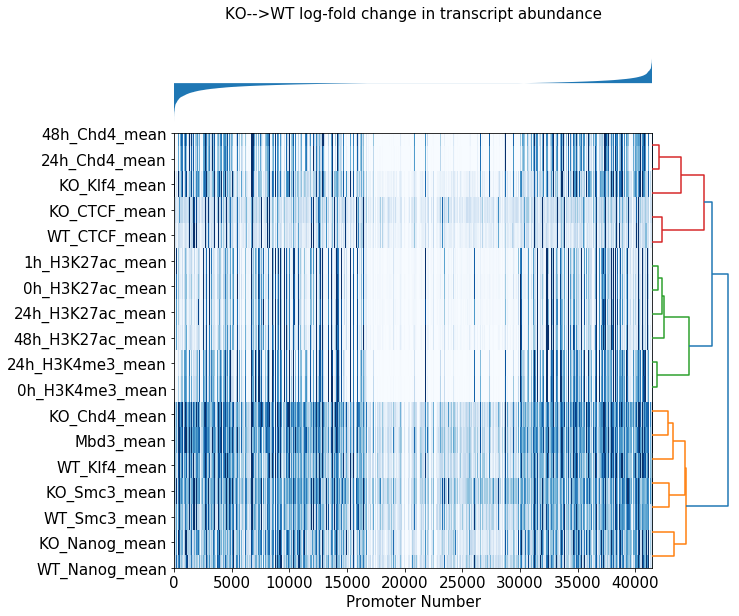

In [94]:
featnames = tmp.columns.values[5:]

sys.setrecursionlimit(2000)

fig = plt.figure(figsize = (10,10))
fig.tight_layout()

gs = grd.GridSpec(2,
                  2,
                  height_ratios=[1,4],
                  width_ratios=[6,1],
                  hspace=0,
                  wspace=0)

ax1 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[0,0])
ax3 = plt.subplot(gs[1,1])

ax2.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax3.xaxis.set_visible(False)

R2 = plot_dendrogram(model2,
                     truncate_mode='level',
                     p=60,
                     get_leaves = True,
                     orientation = 'right',
                     ax = ax3,
                     distance_sort = 'ascending')[0]

order = np.argsort(targ)
ax2.fill_between(np.arange(len(targ)),
                 targ[order])
ax2.set_xlim([0,len(targ)])
ax2.set_title("KO-->WT log-fold change in transcript abundance",size = 15)

img1 = myarr[order,:]
img1 = img1[:,np.array(R2['leaves'])[::-1]]

ax1.imshow(img1.T, 
           cmap = plt.cm.Blues, 
           vmin = 0, 
           vmax = 1, 
           aspect = 'auto')
reorderedtracks = [featnames[i] for i in np.array(R2['leaves'])[::-1]]
yticks = ax1.set_yticks(np.arange(len(reorderedtracks)))
yticklabs = ax1.set_yticklabels(reorderedtracks)
ax1.set_xlabel("Promoter Number", size = 15)
ax1.tick_params(labelsize = 15)
#ax2.set_title("Excluding signal poor promoters", size = 20)
for ax in [ax2,ax3]:
    ax.spines['top'].set_visible('false')
    ax.spines['bottom'].set_visible('false')
    ax.spines['left'].set_visible('false')
    ax.spines['right'].set_visible('false')
    ax.axis('off')
    

In [95]:
import umap
reducer = umap.UMAP(n_neighbors = 10, 
                    n_components = 2)
reducer.fit(img1)
arr_embedded = reducer.transform(img1)

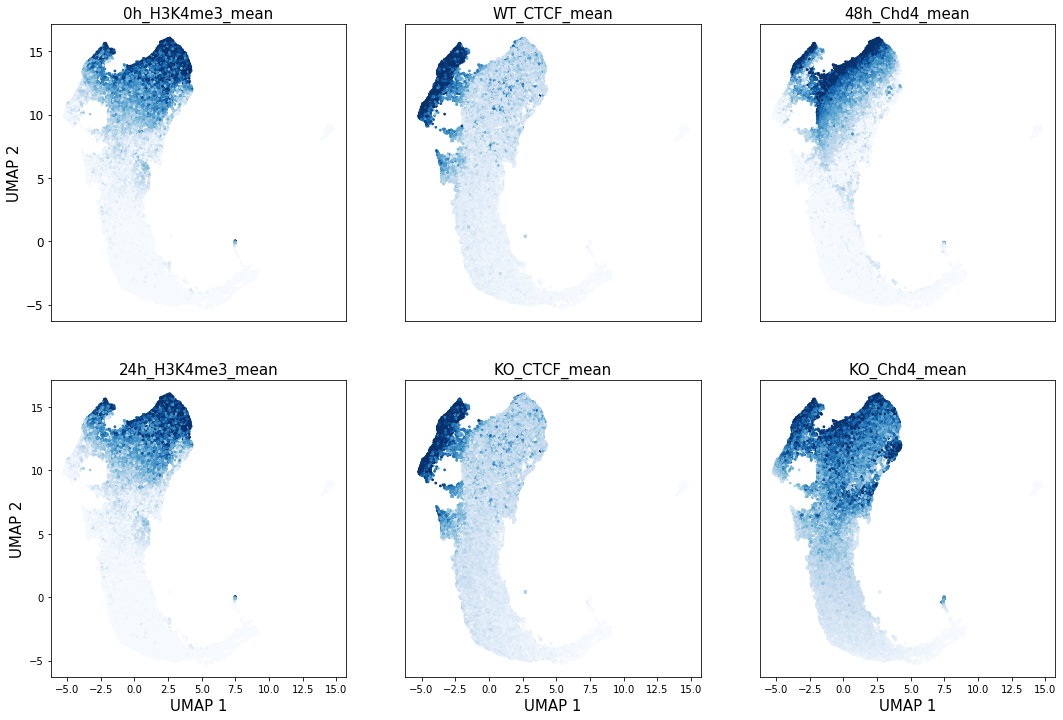

In [96]:
import matplotlib as mpl
fig = plt.figure(figsize = (18,12))
fig.tight_layout()

ax = []
ax.append(plt.subplot2grid((2, 3), (0, 0), colspan=1, rowspan=1))
ax.append(plt.subplot2grid((2, 3), (1, 0), colspan=1, rowspan=1))
ax.append(plt.subplot2grid((2, 3), (0, 1), colspan=1, rowspan=1))
ax.append(plt.subplot2grid((2, 3), (1, 1), colspan=1, rowspan=1))
ax.append(plt.subplot2grid((2, 3), (0, 2), colspan=1, rowspan=1))
ax.append(plt.subplot2grid((2, 3), (1, 2), colspan=1, rowspan=1))

names = ['0h_H3K4me3_mean','24h_H3K4me3_mean','WT_CTCF_mean','KO_CTCF_mean','48h_Chd4_mean','KO_Chd4_mean']
for idx, item in enumerate([np.where(np.array(reorderedtracks) ==name)[0][0] for name in names]):
    cols = img1[:,item]
    ax[idx].scatter(arr_embedded[:,0], 
               arr_embedded[:,1],
               c= cols, 
               cmap = plt.cm.Blues,
               vmin = 0,
               vmax = 1,
               s= 3,
               label = "Hub") 
    
    ax[idx].set_title(names[idx],size = 15)

ax[0].tick_params(labelsize = 12)
ax[1].set_xlabel("UMAP 1", size = 15)
ax[3].set_xlabel("UMAP 1", size = 15)
ax[5].set_xlabel("UMAP 1", size = 15)
ax[1].set_ylabel("UMAP 2", size = 15)
ax[0].set_ylabel("UMAP 2", size = 15)

ax[0].get_xaxis().set_visible(False)
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)    
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[4].get_xaxis().set_visible(False)


Text(0.5, 1.0, 'Downregulated Genes\n(intensity = amount of downregulation)')

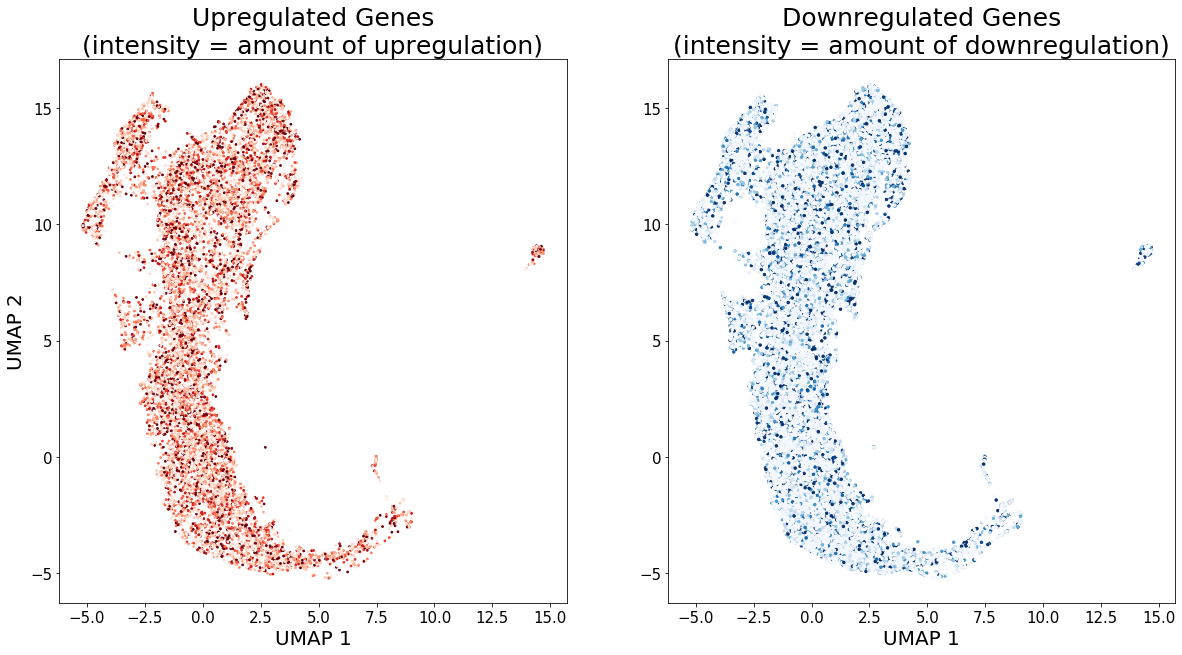

In [97]:
fig, ax = plt.subplots(1,2,figsize = (20,10))
cols = targ

idxs = cols>0
ax[0].scatter(arr_embedded[idxs,0],
           arr_embedded[idxs,1],
           c= cols[idxs],
           vmin = 0,
           vmax = np.percentile(cols[idxs],90),
           cmap = plt.cm.Reds,
           s= 3,
           label = "promoter")

idxs = cols<0
ax[1].scatter(arr_embedded[idxs,0],
           arr_embedded[idxs,1],
           c= cols[idxs],
           vmax = 0,
           vmin = np.percentile(cols[idxs],10),
           cmap = plt.cm.Blues_r,
           s= 6,
           label = "promoter")

for idx in [0,1]:
    ax[idx].spines['top'].set_visible('false')
    ax[idx].spines['bottom'].set_visible('false')
    ax[idx].spines['left'].set_visible('false')
    ax[idx].spines['right'].set_visible('false')
    ax[idx].set_xlabel("UMAP 1",size = 20)
    ax[idx].tick_params(labelsize = 15)
ax[0].set_ylabel("UMAP 2",size = 20)
ax[0].set_title("Upregulated Genes\n(intensity = amount of upregulation)",size = 25)
ax[1].set_title("Downregulated Genes\n(intensity = amount of downregulation)",size= 25)

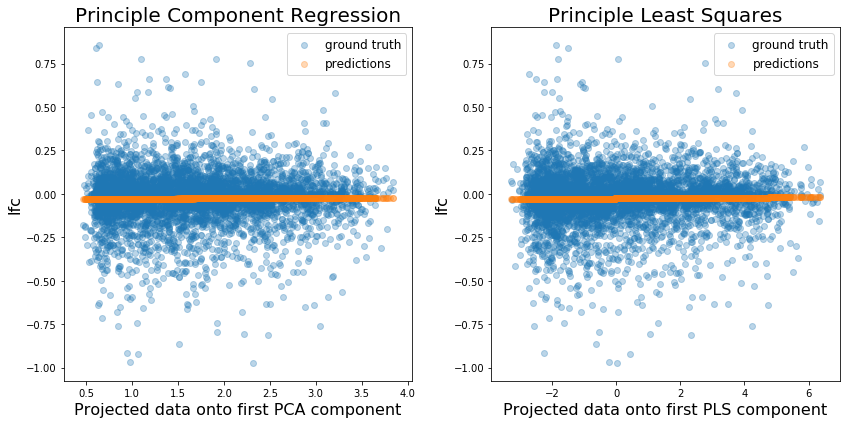

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

rng = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(img1, cols, random_state=rng)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps['pca']  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(pca.transform(X_test), y_test, alpha=.3, label='ground truth')
axes[0].scatter(pca.transform(X_test), pcr.predict(X_test), alpha=.3,
                label='predictions')
axes[0].set_xlabel('Projected data onto first PCA component',size = 16)
axes[0].set_ylabel('lfc', size = 16)
axes[0].set_title('Principle Component Regression',size = 20)
axes[0].legend(prop = {'size':12})

axes[1].scatter(pls.transform(X_test), y_test, alpha=.3, label='ground truth')
axes[1].scatter(pls.transform(X_test), pls.predict(X_test), alpha=.3,
                label='predictions')
axes[1].set_xlabel('Projected data onto first PLS component',size = 16)
axes[1].set_ylabel('lfc', size = 16)
axes[1].set_title('Principle Least Squares',size = 20)

axes[1].legend(prop = {'size':12})
plt.tight_layout()
plt.show()

In [72]:
from sklearn.linear_model import RidgeCV as RCV
regr = RCV()
regr.fit(arrPT, cols)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

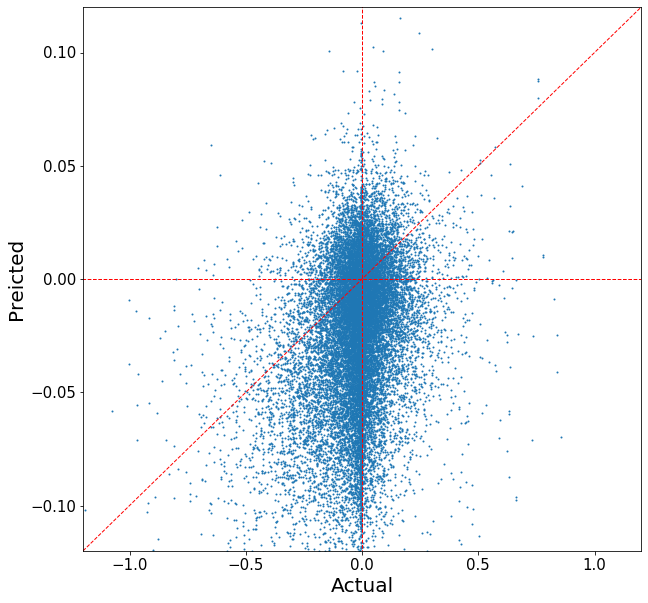

In [74]:
fig,ax = plt.subplots(1, figsize = (10,10))
ax.scatter(cols, 
           regr.predict(arrPT),
           s = 1)
ax.tick_params(labelsize = 15)
ax.set_xlabel("Actual",size = 20)
ax.set_ylabel("Preicted",size = 20)
ax.vlines(0,-0.25,0.15,linestyle = '--',linewidth = 1, color = 'red')
ax.hlines(0,-1.5,1.5,linestyle = '--',linewidth = 1, color = 'red')
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-0.12,0.12])

xlim = ax.get_xlim()
ylim= ax.get_ylim()
plt.plot(xlim,ylim,linestyle = '--',linewidth = 1, color = 'red')

In [19]:
bigwig_paths = {'Mbd3':'/disk2/dh486/bigwigs/GSEXXXXXHendrich20150626_Mbd3_ESC_treat_pileup_filter_norm.bw',
           'CTCF_WT': '/disk2/dh486/bigwigs/GSEXXXXXLaue_CTCF_dipmESC_treat_pileup_filter_norm.bw',
           'CTCF_KO':'/disk2/dh486/bigwigs/GSEXXXXXLaue_CTCF_MBD3nullESC_treat_pileup_filter_norm.bw',
           'Smc3_WT': '/disk2/dh486/bigwigs/GSEXXXXXLaue_Smc3_dipmESC_treat_pileup_filter_norm.bw',
           'Smc3_KO': '/disk2/dh486/bigwigs/GSEXXXXXLaue_Smc3_MBD3nullESC_treat_pileup_filter_norm.bw',
           'H3K27ac_0h': '/disk2/dh486/bigwigs/0h_H3K27ac_R1_ERR2588258.Q30.srt.nodup.bam_treat_pileup_filter_norm.bw',
           'H3K27ac_1h': '/disk2/dh486/bigwigs/1h_H3K27ac_R1_ERR2588281.Q30.srt.nodup.bam_treat_pileup_filter_norm.bw',
           'H3K27ac_24h':'/disk2/dh486/bigwigs/24h_H3K27ac_R2_ERR2588319.Q30.srt.nodup.bam_treat_pileup_filter_norm.bw',
           'H3K27ac_48h': '/disk2/dh486/bigwigs/48h_H3K27ac_R1_ERR2588355.Q30.srt.nodup.bam_treat_pileup_filter_norm.bw',
           'Nanog_WT': '/disk2/dh486/bigwigs/WT/GSE71932_Nanog_mESCs_treat_pileup_filter.bw',
           'Nanog_KO':'/disk2/dh486/bigwigs/KO/GSEXXXXXHendrich20150302_Nanog_Mbd3nullESC_treat_pileup_filter.bw',
           'Klf4_WT': '/disk2/dh486/bigwigs/WT/GSEXXXXXHendrich20150302_Klf4_ESC_treat_pileup_filter.bw',
           'Klf4_KO': '/disk2/dh486/bigwigs/KO/GSEXXXXXHendrich20150302_Klf4_Mbd3nullESC_treat_pileup_filter.bw',
           'H3K4me3_0h':'/disk1/wb104/chipseq/Hendrich_H3K4me3/ERR2588261.fastq.Q30.srt.nodup.bam_treat_pileup_filter_norm.bw',
           'H3K4me3_24h':'/disk1/wb104/chipseq/Hendrich_H3K4me3/ERR2588321.fastq.Q30.srt.nodup.bam_treat_pileup_filter_norm.bw'
          } 


rna = pd.read_table("/disk1/dh486/Data/rnaseq/kallisto_ncrna_ERCC92_wayne_processed_abundance_norm.txt")


In [65]:
def mytransform(vec,perc=95):
    vperc = np.percentile(abs(vec),
                          perc,
                          axis=0)
    return np.divide(vec,vperc)

norm = lambda x: np.apply_along_axis(mytransform,
                                                 0,
                                                 x)

tmp = pd.read_csv("Data/raw/target.tsv",
            sep="\t")
arr = tmp.values[:,5:].astype('float')
print(arr.shape)
norm(arr).shape

(41469, 18)


(41469, 18)

In [72]:
tmp = pd.read_csv("Data/raw/target.tsv",
            sep="\t")
arr = tmp.values[:,5:].astype('float')
numchip = arr.shape[1]

#Select top 22k promoters based off total amount of signal
idxs = np.argsort(np.sum(arr,axis=1))[-30000:]
arr = arr[idxs,:]
target = tmp['target'].values
target = target[idxs]

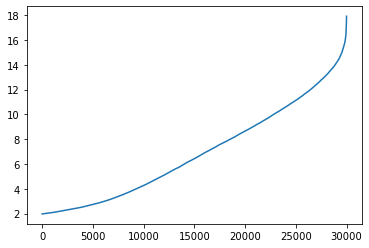

In [73]:
plt.plot(np.sum(arr, axis = 1))

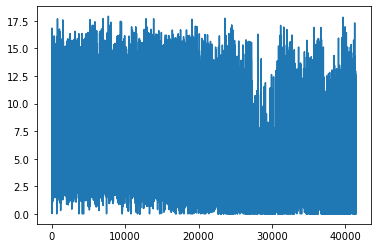

In [74]:
tmp = pd.read_csv("Data/raw/target.tsv",
            sep="\t")
arr = tmp.values[:,5:].astype('float')


plt.plot(np.sum(arr, axis = 1))